# NN Feature Extraction -> Gradient Boosting

In [1]:
import sys
# sys.path.append('..')

from operator import itemgetter
from collections import OrderedDict

from pytorch_utils import *
from lightning_utils import *
from pytorch_vision_utils import *
%load_ext autoreload
%autoreload 2

In [2]:
data_path = r'E:\Data_and_Models\Kaggle_Cards'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Import a NN for feature extraction

In [3]:
# Import the feature-extraction portion of the models

classes = [os.path.basename(p) for p in Path(fr'{data_path}\test').glob('*')]

# The below timm.create_model calls support the features_only = True argument, but that stops before the final convolution before the classification layer,
#   thus (for RexNet 1.0) outputting 5 tensors of (squeezed) shapes
#       torch.Size([16, 112, 112])
#       torch.Size([38, 56, 56])
#       torch.Size([61, 28, 28])
#       torch.Size([128, 14, 14])
#       torch.Size([185, 7, 7])
#   instead of the single one going into classification ([1280, 7, 7]), which is then pooled to 1280 features in the first part of the head portion (1920 for RexNet 1.5).

# model_name = 'RexNet10'
# model = timm.create_model('rexnet_100.nav_in1k', pretrained = True, num_classes = 53).eval().to(device)

model_name = 'RexNet15'
model = timm.create_model('rexnet_150.nav_in1k', pretrained = True, num_classes = 53).eval().to(device)


transforms = timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)

# No training and only feature extraction (up to pooling after final convolution, i.e. for RexNet 1.0 [batch, 1280, 7, 7] -> [batch, 1280], and 1920 for RexNet 1.5)
for param in model.parameters(): param.requires_grad = False
model = nn.Sequential(OrderedDict(stem = model.stem, features = model.features, pool = model.head.global_pool))

In [75]:
summ(model, input_size = (32, 3, 224, 224))

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
Sequential (Sequential)                       [32, 3, 224, 224]    [32, 1920]           --                   False
├─ConvNormAct (stem)                          [32, 3, 224, 224]    [32, 48, 112, 112]   --                   False
│    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 48, 112, 112]   (1,296)              False
│    └─BatchNormAct2d (bn)                    [32, 48, 112, 112]   [32, 48, 112, 112]   96                   False
│    │    └─Identity (drop)                   [32, 48, 112, 112]   [32, 48, 112, 112]   --                   --
│    │    └─SiLU (act)                        [32, 48, 112, 112]   [32, 48, 112, 112]   --                   --
├─Sequential (features)                       [32, 48, 112, 112]   [32, 1920, 7, 7]     --                   False
│    └─LinearBottleneck (0)                   [32, 48, 112, 112]   [32, 24, 112, 1

## Extract features

In [16]:
def image_to_features(image: Image, model: torch.nn.Module, transform: tv.transforms.Compose,
                      device: torch.device = 'cuda' if torch.cuda.is_available() else 'cpu') -> torch.Tensor:
    model.eval()
    with torch.inference_mode(): feats = model(transform(image).unsqueeze(0).to(device)).squeeze().to('cpu')
    return feats

AoC1 = image_to_features(Image.open(fr'{data_path}\test\ace of clubs\1.jpg'), model = model, transform = transforms)
AoC1

tensor([ 0.2355,  0.7186, -0.0611,  ..., -0.0343, -0.0181, -0.0071])

In [32]:
def images_to_features(image_folder: str | Path, model: torch.nn.Module, transform: tv.transforms.Compose, class_names: list[str],
                       device: torch.device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    image_folder = Path(image_folder)
    true_classes, features = [], []

    image_paths = list(image_folder.glob('*/*.jpg')) + list(image_folder.glob('*/*.png'))

    # Should not trust e.g. sklearn.preprocessing.LabelEncode to assign class indices later, hence doing it here
    class_map = {v: i for i, v in enumerate(classes)}

    for path in tqdm(image_paths, desc = f'Extracting {image_folder.name} images\' features'):
        img = Image.open(path)

        model.eval()
        with torch.inference_mode(): feats = model(transform(img).unsqueeze(0).to(device)).squeeze().to('cpu')

        true_classes.append(class_map[path.parent.stem])
        features.append(feats)
    
    return np.array(features), np.array(true_classes)

In [77]:
train_features, train_classes = images_to_features(image_folder = fr'{data_path}\train', model = model, transform = transforms, class_names = classes)
valid_features, valid_classes = images_to_features(image_folder = fr'{data_path}\valid', model = model, transform = transforms, class_names = classes)

Extracting train images' features:   0%|          | 0/7624 [00:00<?, ?it/s]

Extracting valid images' features:   0%|          | 0/265 [00:00<?, ?it/s]

In [78]:
valid_features.shape, valid_classes.shape

((265, 1920), (265,))

## Gradient Boosting

In [12]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix

In [80]:
# model_name = 'RexNet10'
model_name = 'RexNet15'

# lgb_train = lgb.Dataset(train_features, label = train_classes, params = dict(max_bin = 63)) # max_bin is recommended smaller than 255 for gpu and cuda
# lgb_valid = lgb_train.create_valid(valid_features, label = valid_classes, params = dict(max_bin = 63))

# lgb_train.save_binary(f'{data_path}\{model_name}_features_training_data.bin')
# lgb_valid.save_binary(f'{data_path}\{model_name}_features_validation_data.bin')

lgb_train = lgb.Dataset(f'{data_path}\{model_name}_features_training_data.bin')
lgb_valid = lgb.Dataset(f'{data_path}\{model_name}_features_validation_data.bin')

[LightGBM] [Info] Saving data to binary file E:\Data_and_Models\Kaggle_Cards\RexNet15_features_training_data.bin
[LightGBM] [Info] Saving data to binary file E:\Data_and_Models\Kaggle_Cards\RexNet15_features_validation_data.bin


In [10]:
num_iterations = 100
boosting_type = 'gbdt' # 'gbdt' vs 'dart' (dart also comes with more parameters: max_drop, skip_drop, xgboost_dart_mode, uniform_drop)
data_sample_strategy = 'bagging' # 'bagging' vs 'goss' (goss also comes with more parameters: top_rate, other_rate)

# VERY extensive set of parameters to play with: https://lightgbm.readthedocs.io/en/stable/Parameters.html
lgb_params = dict(device = 'gpu', max_bin = 63, # Recommended smaller than 255 for gpu and cuda
    boosting_type = boosting_type, data_sample_strategy = data_sample_strategy,
    objective = 'multiclass', metric = 'multi_logloss', num_class = len(classes), # This already applies softmax => .predict outputs probs, not logits
    # objective = 'cross_entropy', metric = 'cross_entropy',# num_class = 1,
    num_iterations = num_iterations,
    learning_rate = 0.05,
    # num_leaves = 31, max_depth = 10,
    # feature_fraction = 0.7, bagging_fraction = 0.8, bagging_freq = 5,
    # early_stopping_round = 3,
    # lambda_l1 = 0.0, lambda_l2 = 0.0, # Regularisation is also an option
    seed = 42)

In [82]:
gb_model = lgb.train(lgb_params, lgb_train, valid_sets = lgb_valid) # , callbacks=[lgb.early_stopping(stopping_rounds = 5) # unclear precedence with early_stopping_round parameter

c:\Users\Dr-Lo\miniconda3\envs\ML11\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Load from binary file E:\Data_and_Models\Kaggle_Cards\RexNet15_features_training_data.bin
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 120960
[LightGBM] [Info] Number of data points in the train set: 7624, number of used features: 1920
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 970, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1920 dense feature groups (13.96 MB) transferred to GPU in 0.023837 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -4.151565
[LightGBM] [Info] Start training from score -4.079244
[LightGBM] [Info] Start training from score -3.797393
[LightGBM] [Info] Start training from score -3.740559
[LightGBM] [Info] Start training from score -4.011803
[LightGBM] [Info] Start training from score -3.870152
[LightGBM] [Info] Start training from

In [33]:
gb_model.save_model(fr'{data_path}\Models\{model_name}_features_in_{num_iterations}_{data_sample_strategy}_{boosting_type}_lgbm.txt')

## Testing

In [34]:
# boosting_type = 'gbdt' # 'gbdt' vs 'dart'
# data_sample_strategy = 'bagging' # 'bagging' vs 'goss'
gb_model = lgb.Booster(model_file = fr'{data_path}\Models\{model_name}_features_in_{num_iterations}_{data_sample_strategy}_{boosting_type}_lgbm.txt') 

In [87]:
def gb_predict_classes(feats: torch.Tensor, model: lgb.Booster, class_names: list[str]) -> dict[str, float]:
    '''Return the (ordered) predicted probabilities of each class for the given image
    '''
    probs = model.predict([feats], num_iteration = gb_model.best_iteration) # Already probabilities, not logits
    return OrderedDict(sorted({class_names[i]: float(probs[0][i]) for i in range(len(class_names))}.items(), key = itemgetter(1), reverse = True))
    # class_id = torch.argmax(probs, dim = 1)
    # return class_names[class_id.cpu()], probs.unsqueeze(0).max().cpu().item()

gb_predict_classes(AoC1, gb_model, classes)

OrderedDict([('ace of clubs', 0.2968906478712118),
             ('ace of spades', 0.14067288927556318),
             ('four of clubs', 0.06252105540438684),
             ('two of clubs', 0.060650293335429165),
             ('three of clubs', 0.031064289122125575),
             ('five of clubs', 0.028697629890848956),
             ('jack of spades', 0.022433534737327687),
             ('five of spades', 0.021882745161316938),
             ('eight of clubs', 0.017786945509664937),
             ('six of diamonds', 0.0168777982344869),
             ('ten of spades', 0.01468993342793059),
             ('eight of diamonds', 0.014538736304106644),
             ('queen of clubs', 0.013090171612269124),
             ('six of clubs', 0.012149296044630309),
             ('king of spades', 0.010793965683644735),
             ('eight of spades', 0.010757397326808414),
             ('jack of diamonds', 0.009916571488535746),
             ('nine of clubs', 0.00989437558395031),
             ('five of

In [35]:
test_features, test_classes = images_to_features(image_folder = fr'{data_path}\test', model = model, transform = transforms, class_names = classes)

Extracting test images' features:   0%|          | 0/265 [00:00<?, ?it/s]

In [88]:
pred_probs = gb_model.predict(test_features, num_iteration = gb_model.best_iteration) # Already probabilities, not logits
pred_classes = torch.argmax(torch.from_numpy(pred_probs), dim = 1)

In [100]:
image_folder = Path(fr'{data_path}\test')

image_df = pd.DataFrame(dict(path = [str(p) for p in list(image_folder.glob('*/*.jpg')) + list(image_folder.glob('*/*.png'))],
                  true_class = [classes[i] for i in test_classes], pred_class = [classes[i] for i in pred_classes],
                  pred_prob = pred_probs.max(axis = 1), correct = pred_classes.numpy() == test_classes))
image_df = image_df.sort_values(by = ['correct', 'pred_prob'], ascending = [True, False]) # Sort by correctness
image_df

,path,true_class,pred_class,pred_prob,correct
253,E:\Data_and_Models\Kaggle_Cards\test\two of di...,two of diamonds,three of diamonds,0.994575,False
180,E:\Data_and_Models\Kaggle_Cards\test\seven of ...,seven of spades,four of spades,0.980664,False
151,E:\Data_and_Models\Kaggle_Cards\test\queen of ...,queen of diamonds,queen of clubs,0.977928,False
55,E:\Data_and_Models\Kaggle_Cards\test\five of s...,five of spades,four of spades,0.975743,False
48,E:\Data_and_Models\Kaggle_Cards\test\five of d...,five of diamonds,eight of diamonds,0.945987,False
...,...,...,...,...,...
8,E:\Data_and_Models\Kaggle_Cards\test\ace of di...,ace of diamonds,ace of diamonds,0.208306,True
193,E:\Data_and_Models\Kaggle_Cards\test\six of di...,six of diamonds,six of diamonds,0.199330,True
78,E:\Data_and_Models\Kaggle_Cards\test\four of s...,four of spades,four of spades,0.198848,True
117,E:\Data_and_Models\Kaggle_Cards\test\king of h...,king of hearts,king of hearts,0.162180,True


In [87]:
f1_fn = torchmetrics.F1Score(task = 'multiclass', num_classes = 53)
f1_fn(pred_classes, torch.from_numpy(test_classes)).item()

0.5433962345123291

#### Random Sample

alt.VConcatChart(...)
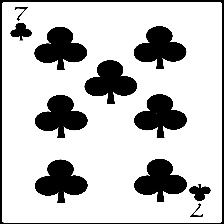
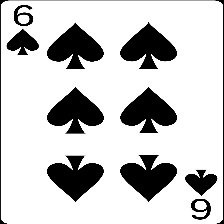
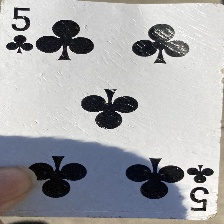
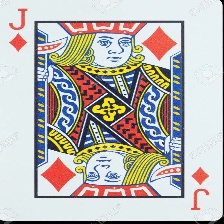
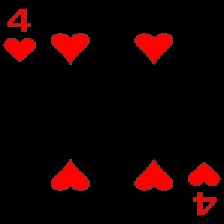
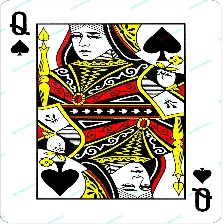
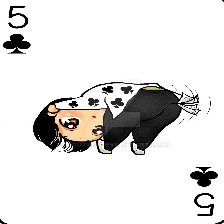
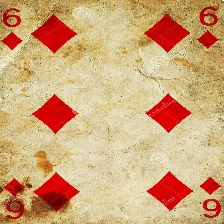
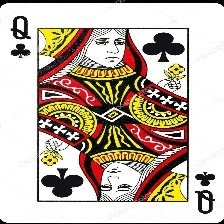
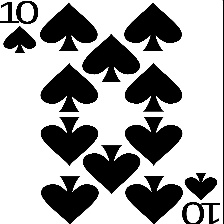
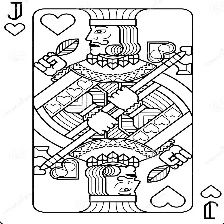
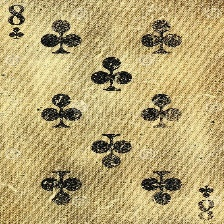

In [101]:
image_pred_grid(image_df.sample(12).copy(), ncols = 6, img_width = 200, img_height = 200, allow_1_col_reduction = True)

#### Most-wrong predictions

alt.VConcatChart(...)
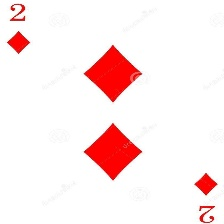
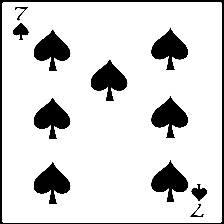
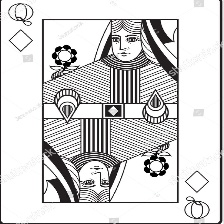
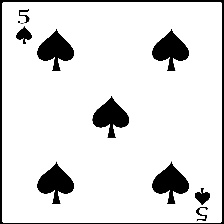
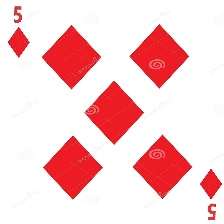
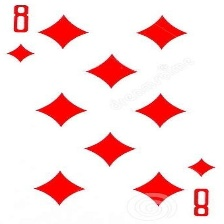
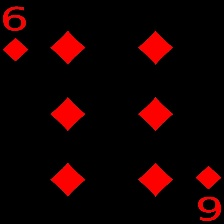
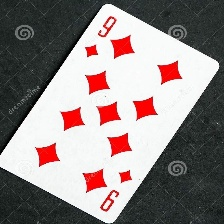
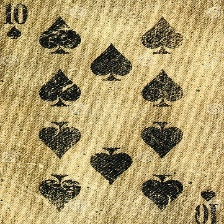
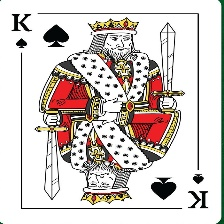
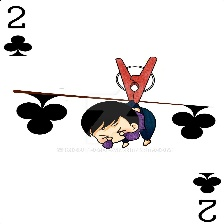
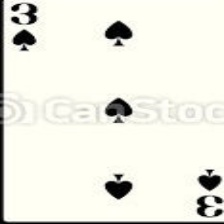

In [102]:
image_pred_grid(image_df.head(12).copy(), ncols = 6, img_width = 200, img_height = 200, allow_1_col_reduction = True)

### Confusion Matrix

In [88]:
conf_mat = confusion_matrix(test_classes, pred_classes)
conf_df = pd.DataFrame([(classes[real], classes[pred], conf_mat[real, pred]) for real in range(len(classes)) for pred in range(len(classes))], columns = ['Real', 'Pred', 'Count'])
conf_df

,Real,Pred,Count
0,ace of clubs,ace of clubs,4
1,ace of clubs,ace of diamonds,0
2,ace of clubs,ace of hearts,0
3,ace of clubs,ace of spades,0
4,ace of clubs,eight of clubs,0
...,...,...,...
2804,two of spades,three of spades,1
2805,two of spades,two of clubs,0
2806,two of spades,two of diamonds,0
2807,two of spades,two of hearts,0


In [89]:
# Confusion Matrix

alt.Chart(conf_df).mark_rect().encode(
    x = 'Pred:O', y = 'Real:O',
    color = alt.Color('Count:Q', scale = alt.Scale(scheme = 'blues'), legend = alt.Legend(title = 'Count'))
).properties(
    title = 'Confusion Matrix'
)

alt.Chart(...)

# Feature Importance

In [90]:
feats_by_importance = pd.DataFrame(dict(feature = gb_model.feature_name(), importance = gb_model.feature_importance())).sort_values('importance', ascending = False)
feats_by_importance

,feature,importance
1141,Column_1141,627
294,Column_294,582
945,Column_945,456
683,Column_683,377
853,Column_853,336
...,...,...
1371,Column_1371,25
1430,Column_1430,24
1461,Column_1461,22
1235,Column_1235,17
